In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

## Test embedding net

In [4]:
! which python

/Users/smsharma/anaconda3/bin/python


In [5]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [6]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [7]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

torch.Size([1, 16384, 1])

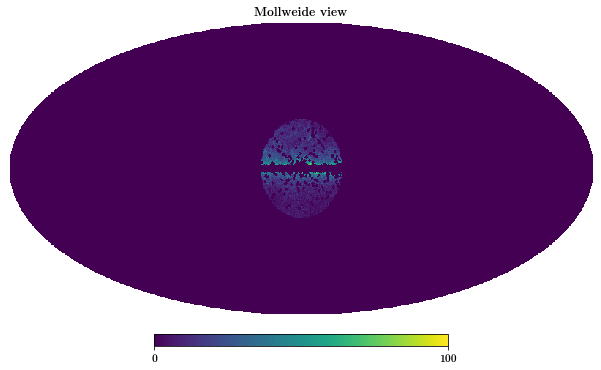

In [8]:
in_map = np.load("../data/fermi_data/fermidata_counts.npy")
in_map[hp_mask] = 0

hp.mollview(in_map, max=100)

in_map = torch.Tensor(in_map[~masks_list[0]])
in_map = in_map.reshape((1, -1, 1))
in_map.shape

In [9]:
log_mean = torch.log(torch.mean(in_map))
log_std = torch.log(torch.var(in_map).sqrt())

log_mean = log_mean.reshape((1, -1, 1))
log_std = log_std.reshape((1, -1, 1))

data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
data_map.shape

torch.Size([1, 16386])

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [25]:
sg = SphericalGraphCNN(nside_list, indexes_list, fc2_out_dim=512, n_aux_var=2).to(device)

In [26]:
sg(data_map)

tensor([[1.3740e-01, 0.0000e+00, 0.0000e+00, 1.7322e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 7.5759e-02, 0.0000e+00, 0.0000e+00, 2.8415e-01, 6.3341e-02,
         2.0330e-02, 0.0000e+00, 2.5567e-01, 5.3563e-03, 0.0000e+00, 0.0000e+00,
         5.6307e-02, 0.0000e+00, 0.0000e+00, 2.5521e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 5.2323e-02, 0.0000e+00, 1.1488e-02, 2.2545e-01,
         2.0069e-01, 0.0000e+00, 3.6998e-01, 1.2075e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4838e-01, 0.0000e+00, 0.0000e+00,
         4.5411e-01, 3.6708e-02, 3.8932e-02, 5.1815e-01, 0.0000e+00, 2.9079e-01,
         0.0000e+00, 4.0587e-01, 7.0443e-02, 5.0934e-01, 0.0000e+00, 0.0000e+00,
         4.9557e-01, 9.9240e-02, 0.0000e+00, 2.2284e-01, 4.7176e-01, 2.9659e-01,
         1.5833e-01, 3.9206e-01, 6.7294e-01, 6.5576e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 5.1133e-01, 0.0000e+00, 0.0000e+00, 1.1790e-01, 0.0000e+00,
         4.0981e-01, 0.0000e

## Test data generation

In [19]:
temp_gce = np.load("../data/fermi_data/template_gce.npy")
temp_dif = np.load("../data/fermi_data/template_dif.npy")

In [20]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF

In [21]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [22]:
from simulations.wrapper import simulator

In [23]:
import sys
from sbi import utils
from sbi import inference

In [24]:
0.1 * np.mean(np.load("../data/fermi_data/fermidata_counts.npy")[np.where(~masks_list[0])])

2.8128173828125003

In [25]:
np.mean(temp_gce[~masks_list[0]])

1.0441547502963613

In [82]:
# Load templates
temp_gce = np.load("../data/fermi_data/template_gce.npy")
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk = np.load("../data/fermi_data/template_dsk.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")

# iso, bub, psc, dif
prior_poiss = [[0.001, 0.001, 0.001, 11.], [1.5, 1.5, 1.5, 16.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [0.5, 20.0, 1.99, 1.99, 50.0, 4.99, 0.5, 20.0, 1.99, 1.99, 50.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.5] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((1,))

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
roi_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask)

[ 0.4790266 16.555515   1.3929979 -8.841435  11.290703   1.6871012]
[ 0.3997533 10.32778    1.9856184 -9.124244  21.050821   2.8817654]


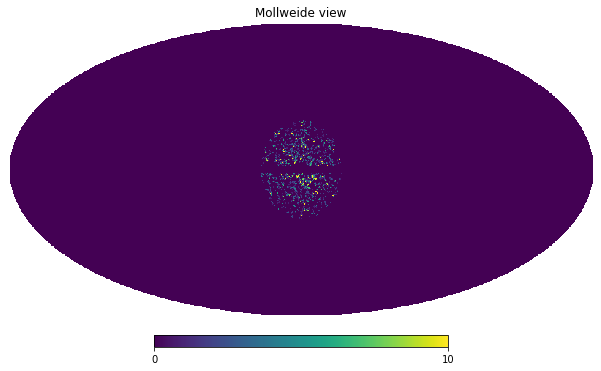

In [106]:
# simulator(theta, temps_poiss, temps_ps, mask_sim, mask_roi, norm=False)

theta = thetas[0]

temps_poiss = [temp_gce, temp_iso, temp_bub, temp_psc, temp_dif]
temps_ps = [temp_gce, temp_dsk]

test_map_temp = simulator(theta.detach().numpy(), temps_poiss, temps_ps, masks_list[0], roi_mask, pc_inst.psf_r_func)
test_map = np.zeros(hp.nside2npix(128))
test_map[np.where(~masks_list[0])] = test_map_temp[0, :-2]
hp.mollview(test_map, max=10)

In [107]:
test_map_temp[0, -2:]

array([-0.98372208,  0.29641642])

In [71]:
test_map_temp[0, -1]

4.844286956964161

In [72]:
from tqdm import *

In [73]:
# set prior distribution for the parameters 
prior = utils.BoxUniform(low=torch.tensor([0.001, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1]), high=torch.tensor([0.5, 0.5, 20.0, 1.99, 1.99, 50.0, 4.99]))

In [74]:
np.sum(~masks_list[0])

16384

In [75]:
# number_presimulated = 100

# theta_presimulated = prior.sample((number_presimulated,))
# x_presimulated = [simulator(theta.detach().numpy(), masks_list[0], temp_gce, pc_inst.psf_r_func, temp_dif, norm_dif=12.0) for theta in tqdm(theta_presimulated)]

In [76]:
theta_presimulated = np.load("/scratch/sm8383/sbi-fermi/data/samples/theta_train_0.npy")
x_presimulated = np.load("/scratch/sm8383/sbi-fermi/data/samples/x_train_0.npy")

In [77]:
len(x_presimulated)

1000

In [78]:
invalid_idx = np.ones(len(x_presimulated)).astype(np.int32)
for idx in tqdm(range(len(x_presimulated))):
    if np.sum(np.isnan(x_presimulated[idx])) + np.sum(np.isinf(x_presimulated[idx])):
        invalid_idx[idx] = 0

100%|██████████| 1000/1000 [00:00<00:00, 18357.42it/s]


In [79]:
x_presimulated = np.array(x_presimulated)[invalid_idx.astype(bool)]
theta_presimulated = np.array(theta_presimulated)[invalid_idx.astype(bool)]

In [80]:
len(theta_presimulated)

1000

In [81]:
np.save("../data/samples/x_small_train.npy", x_presimulated)
np.save("../data/samples/theta_small_train.npy", theta_presimulated)

In [73]:
theta_presimulated = torch.Tensor(theta_presimulated)
x_presimulated = torch.Tensor(x_presimulated)

In [10]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list)

## SNPE

In [14]:
# from sbi.inference import SNPE
from sbi.inference import PosteriorEstimator
from sbi import utils
from sbi import inference

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
# iso, bub, psc, dif
prior_poiss = [[0.001, 0.001, 0.001, 11.], [1.5, 1.5, 1.5, 16.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [0.5, 20.0, 1.99, 1.99, 50.0, 4.99, 0.5, 20.0, 1.99, 1.99, 50.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.5] + prior_poiss[1] + prior_ps[1]))

In [39]:
# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                          device=device.type)

In [40]:
# density_estimator = inference_inst.train(x="/scratch/sm8383/sbi-fermi/data/samples/x_small_train.npy",
#                                          theta="/scratch/sm8383/sbi-fermi/data/samples/theta_small_train.npy",
#                                          proposal=prior,
#                                          training_batch_size=100, max_num_epochs=50)

In [41]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

In [42]:
run_id = '599017116cc84d1cb8c171d687cdf67e'

data_dir = '/scratch/sm8383/sbi-fermi/data/'
# tracking_uri = "file:{}/logs/mlruns".format(data_dir)
# mlflow.set_tracking_uri(tracking_uri)
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-fermi/data/logs/mlruns/2/' + run_id + '/artifacts/density_estimator')

2021/01/03 10:37:28 WARNING mlflow.pytorch: Stored model version '1.7.0' does not match installed PyTorch version '1.6.0'


In [43]:
# density_estimator = torch.load("../data/models/vanilla_dif.pt", map_location=torch.device('cpu'))

In [47]:
from sbi.utils import x_shape_from_simulation

x_presimulated = torch.Tensor(np.load("../data/samples/x_train_float_all_33.npy"))
theta_presimulated = torch.Tensor(np.load("../data/samples/theta_train_float_all_33.npy"))

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)

In [48]:
posterior = inference_inst.build_posterior(density_estimator)

In [49]:
import corner

In [50]:
x_presimulated[0].view(-1, 16386, 1).shape

torch.Size([1, 16386, 1])

In [52]:
posterior_samples[0][5:5+6]

tensor([ 0.4193, 13.0441,  1.4755,  1.1536, 36.9978,  1.0592])

In [61]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [62]:
def dnds_conv(s_ary, theta):
    dnds_ary = dnds(s_ary, [1] + list(theta[1:]))
    A = theta[0] / np.trapz(s_ary * dnds_ary, s_ary)
    dnds_ary = dnds(s_ary, [A] + list(theta[1:]))
    return dnds_ary

In [63]:
x_presimulated[truth_idx].shape

torch.Size([1, 16386])

In [64]:
# data_map

In [125]:
poiss_labels = [r"iso", r"bub", r"psc", r"dif$\,\times 0.1$"]
ps_labels = [r"gce ps", r"dsk ps"]
temps_poiss = [temp_iso, temp_bub, temp_psc, temp_dif]
temps_ps = [temp_gce, temp_dsk]

In [145]:
ax[0][3]

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

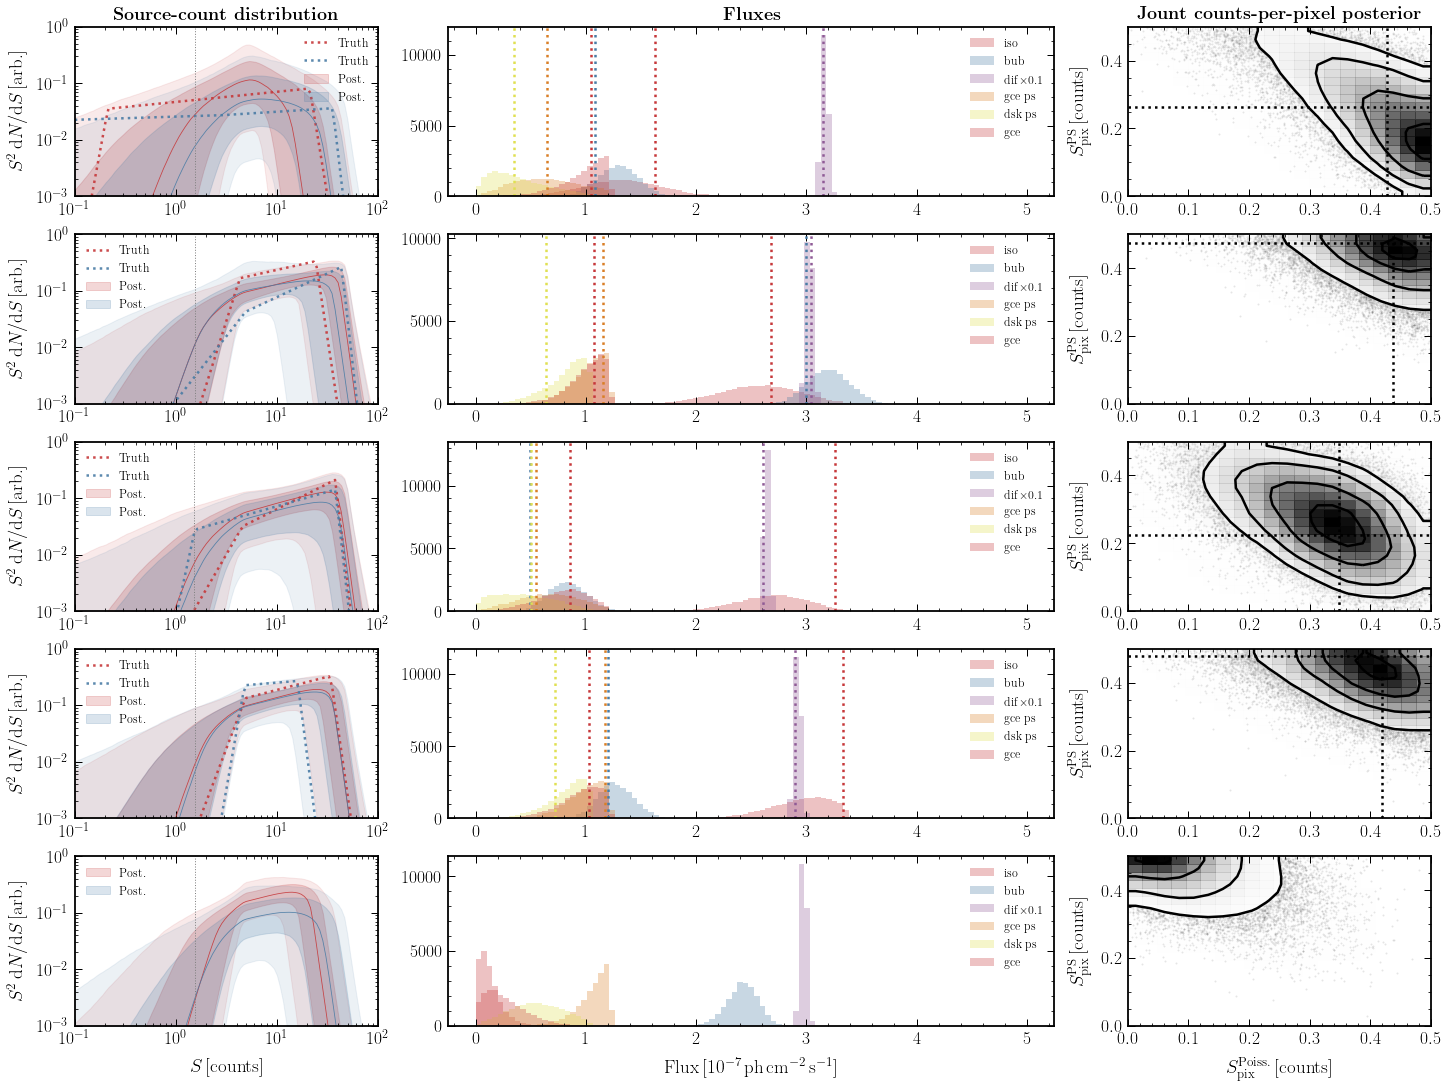

In [152]:
pixarea = hp.nside2pixarea(128, degrees=False)

nrows = 5
idx_start = 66
# fig, ax = plt.subplots(ncols=4, nrows=nrows, constrained_layout=True, figsize=(20, 15))

fig = plt.figure(constrained_layout=True, figsize=(20, 15))
gs = fig.add_gridspec(nrows=nrows, ncols=4)

ax = [[None] * 4] * nrows

for i_r in range(nrows):
    
    truth_idx = idx_start + i_r
    theta_truth = theta_presimulated[truth_idx]
    x_o = x_presimulated[truth_idx]
    
    if i_r == nrows - 1:
        x_o = data_map
        is_data = True
    else:
        is_data = False
        
    posterior_samples = posterior.sample((20000,), x=x_o)

    s_ary = np.logspace(-1, 2, 100)
    
    ax[i_r][0] = fig.add_subplot(gs[i_r,0])
    
    for idx_ps, i_param_ps in enumerate([5, 11]):
        dnds_ary = [dnds_conv(s_ary, theta) for theta in posterior_samples[:,i_param_ps:i_param_ps+6].detach().numpy()]

        ax[i_r][0].plot(s_ary, np.median(s_ary ** 2 * dnds_ary, axis=0), color=cols_default[idx_ps], lw=0.8)
        ax[i_r][0].fill_between(s_ary, np.percentile(s_ary ** 2 * dnds_ary, [16], axis=0)[0], np.percentile(s_ary ** 2 * dnds_ary, [84], axis=0)[0], alpha=0.2, color=cols_default[idx_ps], label="Post.")
        ax[i_r][0].fill_between(s_ary, np.percentile(s_ary ** 2 * dnds_ary, [2.5], axis=0)[0], np.percentile(s_ary ** 2 * dnds_ary, [97.5], axis=0)[0], alpha=0.1, color=cols_default[idx_ps])
        
        
        if not is_data:
            ax[i_r][0].plot(s_ary, s_ary ** 2 * dnds_conv(s_ary, theta_truth[i_param_ps:i_param_ps+6].detach().numpy()), color=cols_default[idx_ps], ls='dotted', label="Truth")
    
    ax[i_r][0].set_xscale("log")
    ax[i_r][0].set_yscale("log")

    ax[i_r][0].set_ylim(1e-3, 1e0)
    ax[i_r][0].set_xlim(1e-1, 1e2)
    
    ax[i_r][0].axvline(np.sqrt(x_presimulated[truth_idx,0,-1]), lw=1, ls='dotted', color='grey')
    
    ax[i_r][0].set_ylabel(r"$S^2\,\mathrm{d}N/\mathrm{d}S$\,[arb.]")
    
    if i_r == nrows - 1:
        ax[i_r][0].set_xlabel(r"$S$\,[counts]")
     
    if i_r == 0:
        ax[i_r][0].set_title(r"\bf{Source-count distribution}")

    ax[i_r][0].legend(fontsize=12)
        
    
    ax[i_r][1] = fig.add_subplot(gs[i_r,-1])
    
    corner.hist2d(posterior_samples[:,0].detach().numpy(), posterior_samples[:,5].detach().numpy(), ax=ax[i_r][1], smooth=1)
    if not is_data:
        ax[i_r][1].axvline(theta_truth[0], color='k', ls='dotted')
        ax[i_r][1].axhline(theta_truth[5], color='k', ls='dotted')
    ax[i_r][1].set_xlim(-0., 0.5)
    ax[i_r][1].set_ylim(-0., 0.5)

    ax[i_r][1].set_ylabel(r"$S_\mathrm{pix}^\mathrm{PS}$\,[counts]")
    if i_r == nrows - 1:
        ax[i_r][1].set_xlabel(r"$S_\mathrm{pix}^\mathrm{Poiss.}$\,[counts]")
    if i_r == 0:
        ax[i_r][1].set_title(r"\bf{Jount counts-per-pixel posterior}")
    
    ax[i_r][2] = fig.add_subplot(gs[i_r,1:-1])
    
    bins = np.linspace(0., 5, 100)
    
    for i_temp_poiss in range(len(temps_poiss)):
        if i_temp_poiss == 2:
            continue
            
        if i_temp_poiss == 3:
            divide_by = 1e-6
        else:
            divide_by = 1e-7

        
        ax[i_r][2].hist(posterior_samples[:, 1 + i_temp_poiss] * np.mean(temps_poiss[i_temp_poiss][~roi_mask] / fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[i_temp_poiss], bins=bins, alpha=0.3, label=poiss_labels[i_temp_poiss] )
        if not is_data:
            ax[i_r][2].axvline(theta_truth[1 + i_temp_poiss] * np.mean(temps_poiss[i_temp_poiss][~roi_mask] / fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[i_temp_poiss], ls='dotted')
    
    for i_temp_ps, idx_ps in enumerate([5,11]):
        divide_by = 1e-7
        ax[i_r][2].hist(posterior_samples[:, idx_ps] * np.mean(temps_ps[i_temp_ps][~roi_mask]) / np.mean(temps_ps[i_temp_ps][~masks_list[0]]) / np.mean(fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[len(temps_poiss) + i_temp_ps], bins=bins, alpha=0.3, label=ps_labels[i_temp_ps] )
        if not is_data:
            ax[i_r][2].axvline(theta_truth[idx_ps] * np.mean(temps_ps[i_temp_ps][~roi_mask]) / np.mean(temps_ps[i_temp_ps][~masks_list[0]]) / np.mean(fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[len(temps_poiss) + i_temp_ps], ls='dotted')
    
    i_temp_ps = 0
    ax[i_r][2].hist(posterior_samples[:, 0] * np.mean(temps_ps[i_temp_ps][~roi_mask]) / np.mean(temps_ps[i_temp_ps][~masks_list[0]]) / np.mean(fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[-1], bins=bins, alpha=0.3, label='gce' )
    if not is_data:
        ax[i_r][2].axvline(theta_truth[0] * np.mean(temps_ps[i_temp_ps][~roi_mask]) / np.mean(temps_ps[i_temp_ps][~masks_list[0]]) / np.mean(fermi_exp[~roi_mask]) / pixarea / divide_by, color=cols_default[-1], ls='dotted')

    ax[i_r][2].legend(fontsize=12)
    
    if i_r == nrows - 1:
        ax[i_r][2].set_xlabel(r"Flux\,[$10^{-7}$\,ph\,cm$^{-2}$\,s$^{-1}$]")
    if i_r == 0:
        ax[i_r][2].set_title(r"\bf{Fluxes}")

# plt.savefig("/Users/smsharma/Desktop/neural_density_estimation.pdf")

In [150]:
np.mean(temp_gce[~masks_list[0]])

1.0441547502963613

In [124]:
np.mean(temp_gce[~roi_mask]) / np.mean(temp_gce[~masks_list[0]]) / np.mean(fermi_exp[~roi_mask])

1.56738425635046e-11

In [99]:
posterior_samples[:, 1 + i_temp_poiss]

tensor([11.8076, 11.7541, 12.0120,  ..., 11.8528, 11.7952, 11.8091])

In [100]:
posterior_samples[:, 1 + i_temp_poiss] * np.mean(temps_poiss[i_temp_poiss][~roi_mask] / fermi_exp[~roi_mask]) / 1e-11

tensor([17.8521, 17.7712, 18.1611,  ..., 17.9205, 17.8334, 17.8543])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 array([0.        , 0.15789474, 0.31578947, 0.47368421, 0.63157895,
        0.78947368, 0.94736842, 1.10526316, 1.26315789, 1.42105263,
        1.57894737, 1.73684211, 1.89473684, 2.05263158, 2.21052632,
        2.36842105, 2.52631579, 2.68421053, 2.84210526, 3.        ]),
 <a list of 19 Patch objects>)

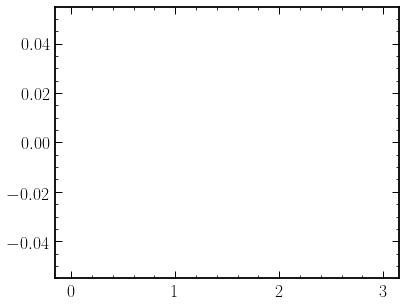

In [98]:
i_temp_poiss = 3
plt.hist(posterior_samples[:, 1 + i_temp_poiss] * np.mean(temps_poiss[i_temp_poiss][~roi_mask] / fermi_exp[~roi_mask]) / 1e-11, color=cols_default[i_temp_poiss], bins=bins, alpha=0.3, )

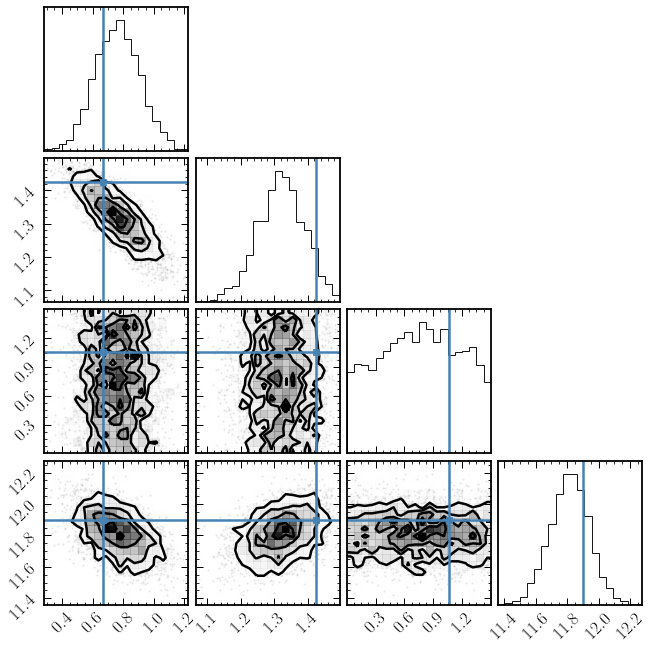

In [73]:
corner.corner(posterior_samples[:, 1:5], truths=theta_truth[1:5]);

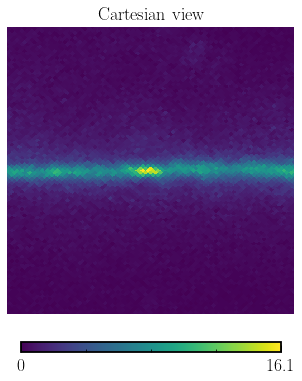

In [68]:
test_map = np.zeros(hp.nside2npix(128))
test_map[np.where(~masks_list[0])] = x_presimulated[51,0,:-1]
embed = hp.cartview(test_map, lonra=[-20,20], latra=[-20,20], return_projected_map=True);